In [1]:
import mesa

from epstein_network_civil_violence.agent import Inhabitant, Police
from epstein_network_civil_violence.model import EpsteinNetworkCivilViolence
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import ListedColormap

we mainly focus on two things here: legitimacy_impact and time
legitimacy_impact is how fast would the mean field change work, you can see the mean_field_spread function in agent.py:
    self.regime_legitimacy += self.legitimacy_impact * (mean_legitimacy - self.regime_legitimacy)

And I might make some agents' legitimacy never change to create some patterns.

different legitimacy impacts to compare in different time steps:

In [2]:
# Function to create a custom colormap
def create_colormap():
    """
    Create a colormap with 0 as white and the rest as 'viridis'.
    Returns:
        ListedColormap: Custom colormap
    """
    cmap = plt.cm.viridis
    # Make 0 into white
    colors = cmap(np.arange(cmap.N))
    colors[0, :] = np.array([1, 1, 1, 1])
    new_cmap = ListedColormap(colors)
    return new_cmap

# Function to run the model and collect heatmap data
def run_model_and_collect_data_multi_impact(legitimacy_impacts, time_steps):
    """
    Run the EpsteinNetworkCivilViolence model for different legitimacy impacts
    and collect heatmap data at specified time steps.
    Args:
        legitimacy_impacts (list): List of different legitimacy impact values to test
        time_steps (list): List of time steps to capture
    Returns:
        dict: Heatmap data for each legitimacy impact and time step
    """
    heatmaps = {impact: [] for impact in legitimacy_impacts}
    for impact in legitimacy_impacts:
        model = EpsteinNetworkCivilViolence(
            width=80,
            height=80,
            citizen_density=0.9,
            cop_density=0.074,
            citizen_vision=7,
            cop_vision=7,
            legitimacy=0.8,
            max_jail_term=1000,
            active_threshold=0.1,
            arrest_prob_constant=2.3,
            movement=True,
            max_iters=300,
            alpha=0.1,
            jail_factor=1.1,
            legitimacy_impact=impact,
            legitimacy_type="heterogeneous",
            use_mean_field=True,
            legitimacy_width=0.1,
            cop_density_mode='constant',
            legitimacy_mode='constant'
        )
        
        for step in range(max(time_steps) + 1):
            model.step()
            if step in time_steps:
                agent_data = model.datacollector.get_agent_vars_dataframe()
                current_data = agent_data.xs(step, level='Step')
                inhabitant_data = current_data[current_data['breed'] == 'citizen']
                # Get x, y and regime_legitimacy
                x = inhabitant_data.x.values
                y = inhabitant_data.y.values
                legitimacy = inhabitant_data.regime_legitimacy.values
                grid_size = (80, 80)
                heatmap_data = np.zeros(grid_size)
                for i in range(len(x)):
                    heatmap_data[int(x[i]), int(y[i])] = legitimacy[i]
                heatmaps[impact].append(heatmap_data)
    return heatmaps

# Function to plot the heatmaps
def plot_heatmaps(heatmaps, legitimacy_impacts, time_steps):
    """
    Plot heatmaps for each legitimacy impact and time step.
    Args:
        heatmaps (dict): Heatmap data for each legitimacy impact and time step
        legitimacy_impacts (list): List of different legitimacy impact values
        time_steps (list): List of time steps to capture
    """
    fig, axes = plt.subplots(len(legitimacy_impacts), len(time_steps), figsize=(20, 20))
    cmap = create_colormap()

    for i, impact in enumerate(legitimacy_impacts):
        for j, step in enumerate(time_steps):
            ax = axes[i, j]
            im = ax.imshow(heatmaps[impact][j], cmap=cmap, interpolation='nearest', vmin=0.8-0.1, vmax=0.8+0.1)
            if j == 0:
                ax.set_ylabel(f'Legitimacy Impact: {impact}')
            if i == len(legitimacy_impacts) - 1:
                ax.set_xlabel(f'Time step {step}')

    # Adjust the layout to make space for the colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label='Regime Legitimacy')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

C:\Users\liaojw\AppData\Local\Temp\ipykernel_42512\1975321419.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


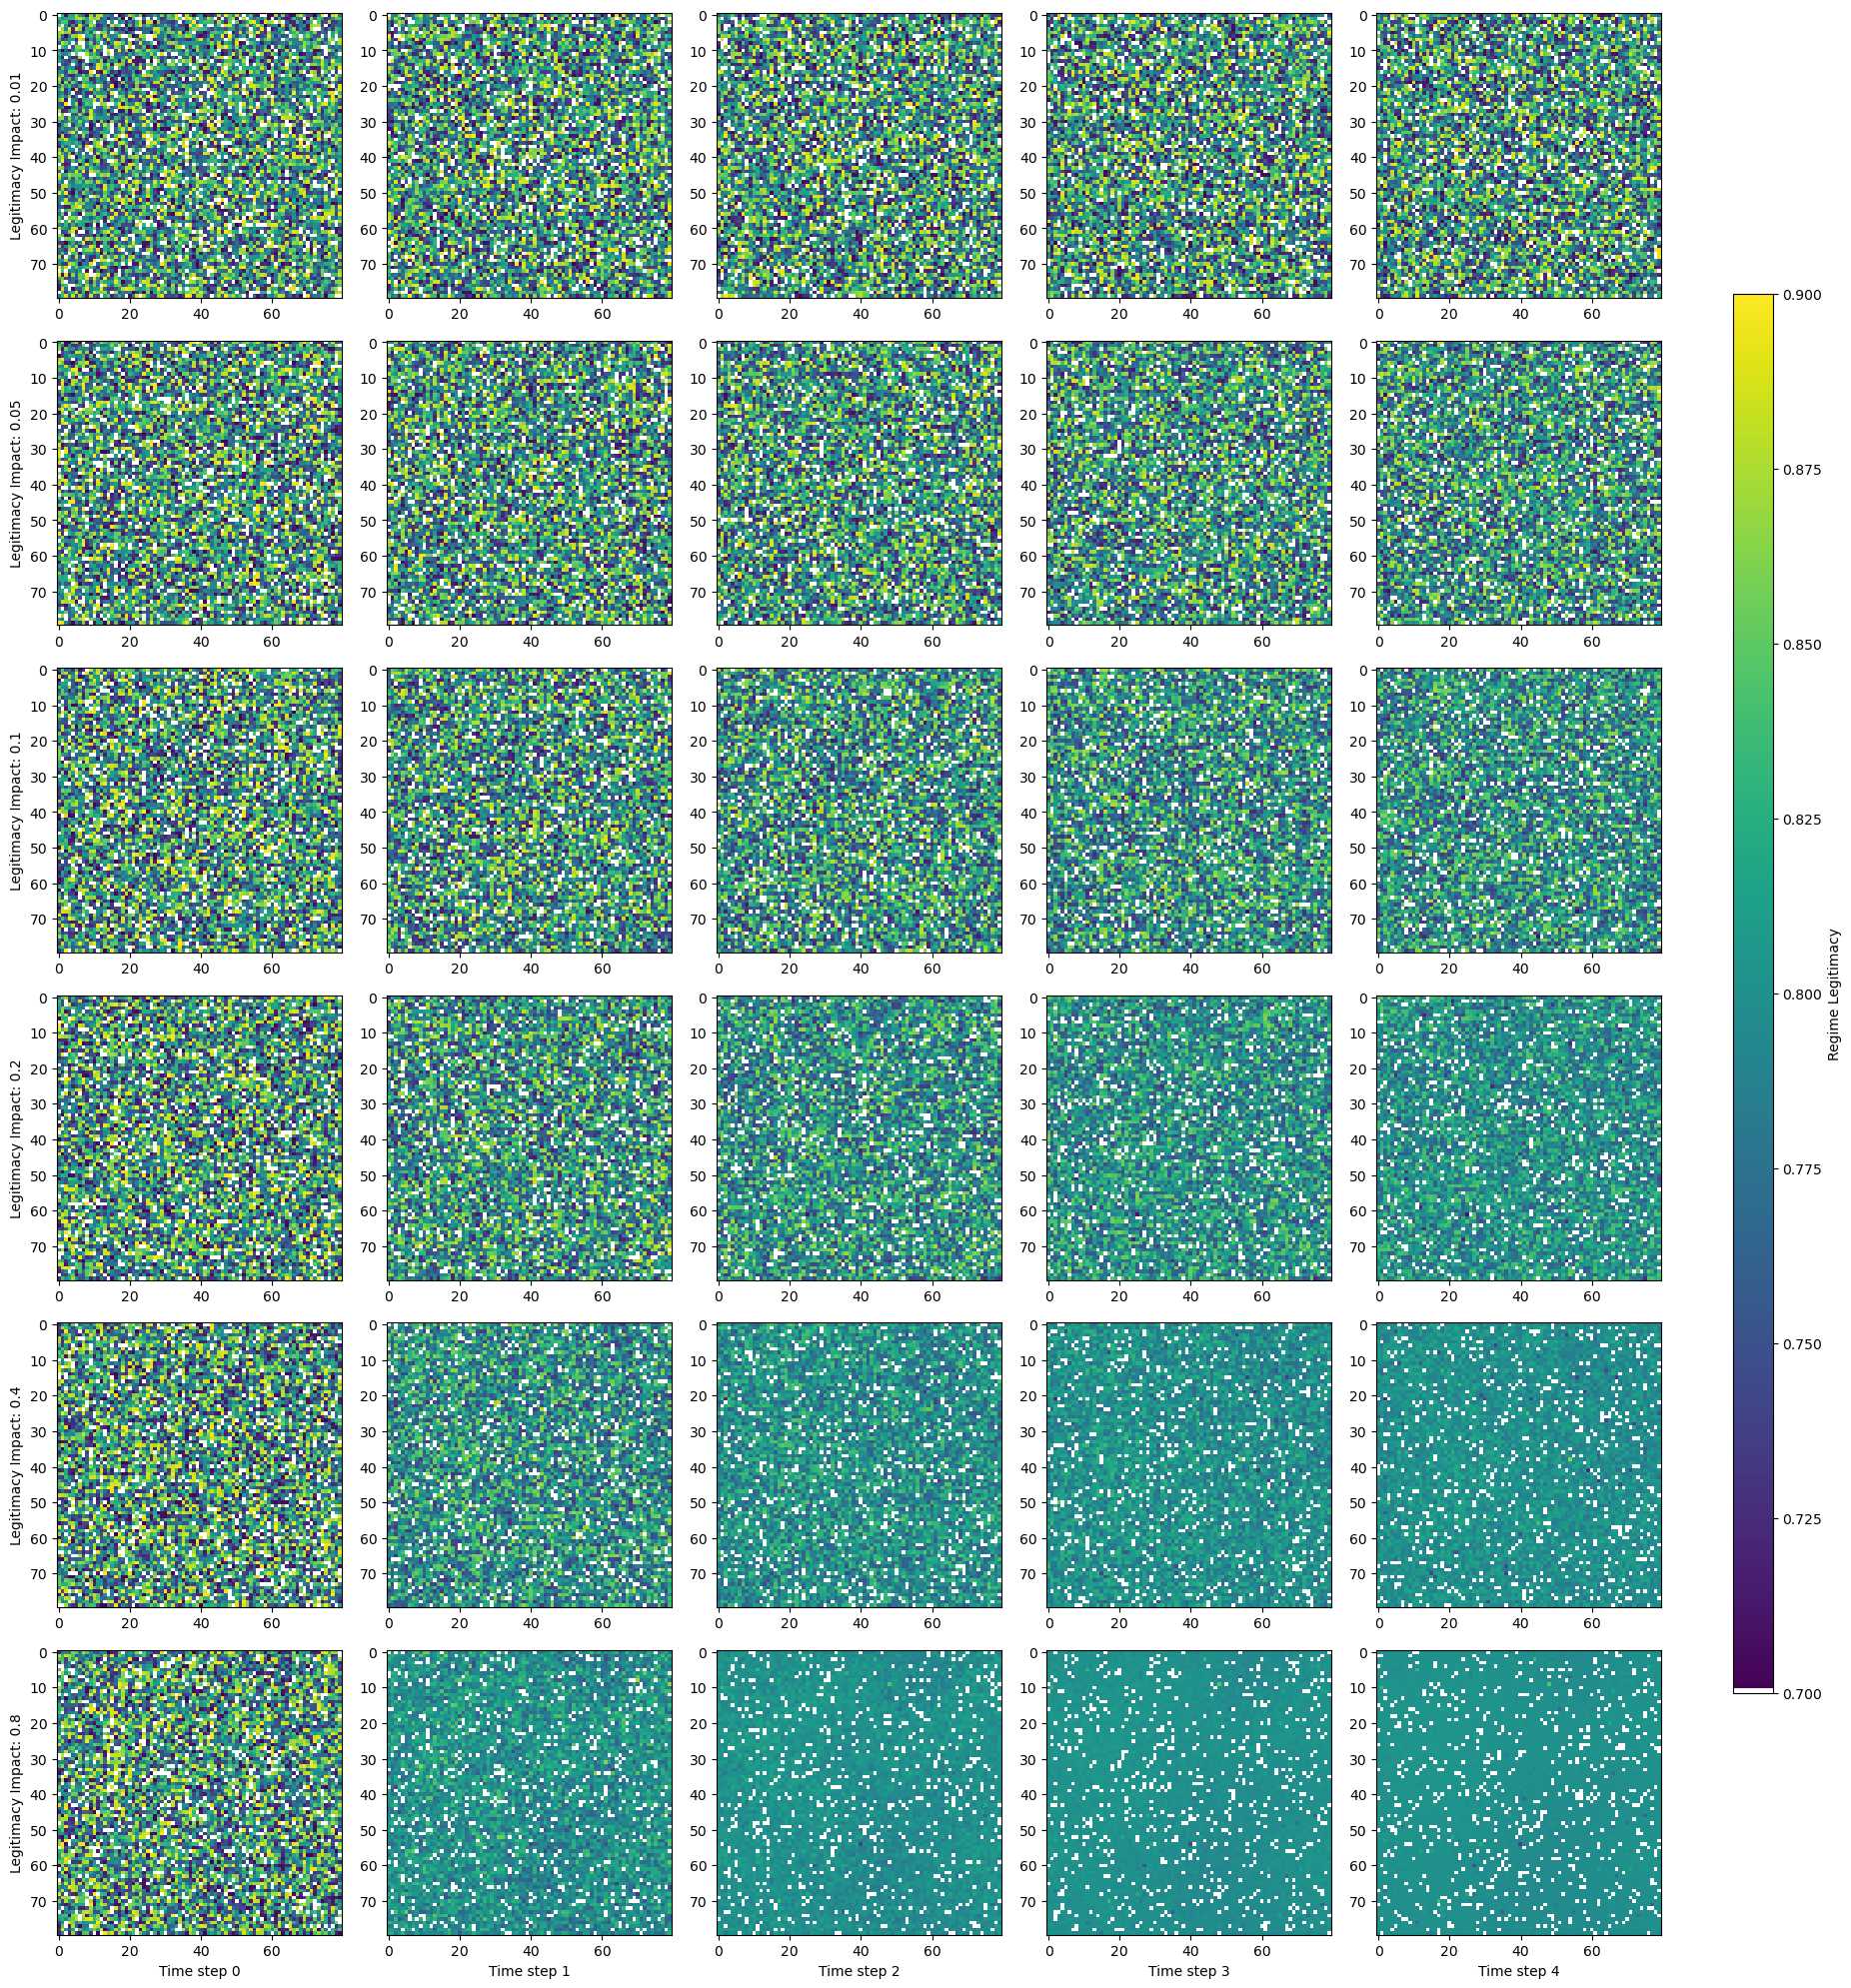

In [3]:
# Main code execution, about 35s to run
if __name__ == "__main__":
    legitimacy_impacts = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
    time_steps = [0, 1, 2, 3, 4]
    heatmaps = run_model_and_collect_data_multi_impact(legitimacy_impacts, time_steps)
    plot_heatmaps(heatmaps, legitimacy_impacts, time_steps)

for a certain legitimacy impact, find how it change via time:

In [4]:
# Function to create a custom colormap
def create_colormap():
    """
    Create a colormap with 0 as white and the rest as 'viridis'.
    Returns:
        ListedColormap: Custom colormap
    """
    cmap = plt.cm.viridis
    # Make 0 into white
    colors = cmap(np.arange(cmap.N))
    colors[0, :] = np.array([1, 1, 1, 1])
    new_cmap = ListedColormap(colors)
    return new_cmap

# Function to create a model instance with specific parameters
def create_model(legitimacy_impact=0.1, legitimacy_type="heterogeneous", legitimacy_matrix = None, legitimacy=0.8, legitimacy_width=0.1, citizen_density=0.9, legitimacy_stability_threshold=0.1):
    """
    Create an instance of EpsteinNetworkCivilViolence model with specific parameters.
    Args:
        legitimacy_impact (float): The impact of legitimacy to use in the model
        legitimacy_matrix (np.array): Matrix specifying the legitimacy by regions
    Returns:
        model: An instance of the model
    """
    model = EpsteinNetworkCivilViolence(
        width=80,
        height=80,
        citizen_density=0.9,
        cop_density=0.074,
        citizen_vision=7,
        cop_vision=7,
        legitimacy=legitimacy,
        max_jail_term=1000,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=300,
        alpha=0.1,
        jail_factor=1.1,
        legitimacy_impact=legitimacy_impact,
        legitimacy_type=legitimacy_type,
        legitimacy_matrix=legitimacy_matrix,
        use_mean_field=True,
        legitimacy_stability_threshold = legitimacy_stability_threshold,
        legitimacy_width=legitimacy_width,
        cop_density_mode='constant',
        legitimacy_mode='constant'
    )
    return model

# Function to run the model and collect heatmap data at specified time steps
def run_model_and_collect_data_over_time(model, time_steps):
    """
    Run the model and collect heatmap data at specified time steps.
    Args:
        model: An instance of the EpsteinNetworkCivilViolence model
        time_steps (list): List of time steps to capture
    Returns:
        list: Heatmap data for each time step
    """
    heatmaps = []
    for step in range(max(time_steps) + 1):
        model.step()
        if step in time_steps:
            agent_data = model.datacollector.get_agent_vars_dataframe()
            current_data = agent_data.xs(step, level='Step')
            inhabitant_data = current_data[current_data['breed'] == 'citizen']
            # Get x, y and regime_legitimacy
            x = inhabitant_data.x.values
            y = inhabitant_data.y.values
            legitimacy = inhabitant_data.regime_legitimacy.values
            grid_size = (80, 80)
            heatmap_data = np.zeros(grid_size)
            for i in range(len(x)):
                heatmap_data[int(x[i]), int(y[i])] = legitimacy[i]
            heatmaps.append(heatmap_data)
    return heatmaps

# Function to plot heatmaps
def plot_heatmaps(heatmaps, time_steps):
    """
    Plot heatmaps for each time step.
    Args:
        heatmaps (list): Heatmap data for each time step
        time_steps (list): List of time steps to capture
    """
    num_cols = 4
    num_rows = (len(time_steps) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    axes = axes.flatten()
    cmap = create_colormap()

    for i, ax in enumerate(axes):
        if i < len(time_steps):

            data_with_nan = np.where(heatmaps[i] == 0, np.nan, heatmaps[i])
            min_value = np.nanmin(data_with_nan)

            im = ax.imshow(heatmaps[i], cmap=cmap, interpolation='nearest', vmin=min_value-0.01, vmax=np.max(heatmaps[i]))
            ax.set_title(f'Time step {time_steps[i]}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
        else:
            fig.delaxes(ax)  # Remove empty subplot

    # Adjust the layout to make space for the colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label='Regime Legitimacy')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# # Function to extract data from the model
# def extract_data(model):
#     """
#     Extract agent data from the model's data collector.
#     Args:
#         model: An instance of the EpsteinNetworkCivilViolence model
#     Returns:
#         DataFrame: Agent data collected by the model
#     """
#     return model.datacollector.get_agent_vars_dataframe()

# Function to plot legitimacy distribution histograms at specified time steps

def plot_legitimacy_histograms(agent_data, time_steps):
    """
    Plot legitimacy distribution histograms at specified time steps.
    Args:
        agent_data (DataFrame): Agent data collected by the model
        time_steps (list): List of time steps to plot histograms for
    """
    num_steps = len(time_steps)
    num_rows = (num_steps + 1) // 2  # Calculate the number of rows needed

    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 3 * num_rows))
    axs = axs.flatten()  # Flatten the array for easy indexing

    for i, step in enumerate(time_steps):
        step_data = agent_data.xs(step, level="Step")
        legitimacy_values = step_data['regime_legitimacy']

        # Plot histogram
        axs[i].hist(legitimacy_values, edgecolor='black', bins=20)
        axs[i].set_title(f'Legitimacy Distribution at Time Step {step}')
        axs[i].set_xlabel('Legitimacy')
        axs[i].set_ylabel('Number of Citizens')

    # Remove any empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

def plot_homogeneous_ratio(models, labels):
    plt.figure(figsize=(10, 6))
    for model, label in zip(models, labels):
        model_data = model.datacollector.get_model_vars_dataframe()
        agent_num = model_data["Active"][0]+model_data["Jailed"][0]+model_data["Quiescent"][0]
        # print(model_data["Stable Agents"])

        stable_agents_data_per = model_data["Stable Agents"]/agent_num

        plt.plot(stable_agents_data_per, label='Homogeneous Agents in '+label + " model")
    plt.xlabel('Step')
    plt.ylabel('Ratio of Stable Agents')
    plt.title('Homogeneous Agents Ratio Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
# Heterogeneous
legitimacy_impact = 0.02
legitimacy_type = "heterogeneous"
time_steps = [0, 5, 10, 20, 30, 40, 80, 100]
heter_model = create_model(legitimacy_impact = legitimacy_impact, legitimacy_type = legitimacy_type, legitimacy=0.5, legitimacy_width=0.3, legitimacy_stability_threshold=0.1)
heter_heatmaps = run_model_and_collect_data_over_time(heter_model, time_steps)

C:\Users\liaojw\AppData\Local\Temp\ipykernel_42512\3615908245.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


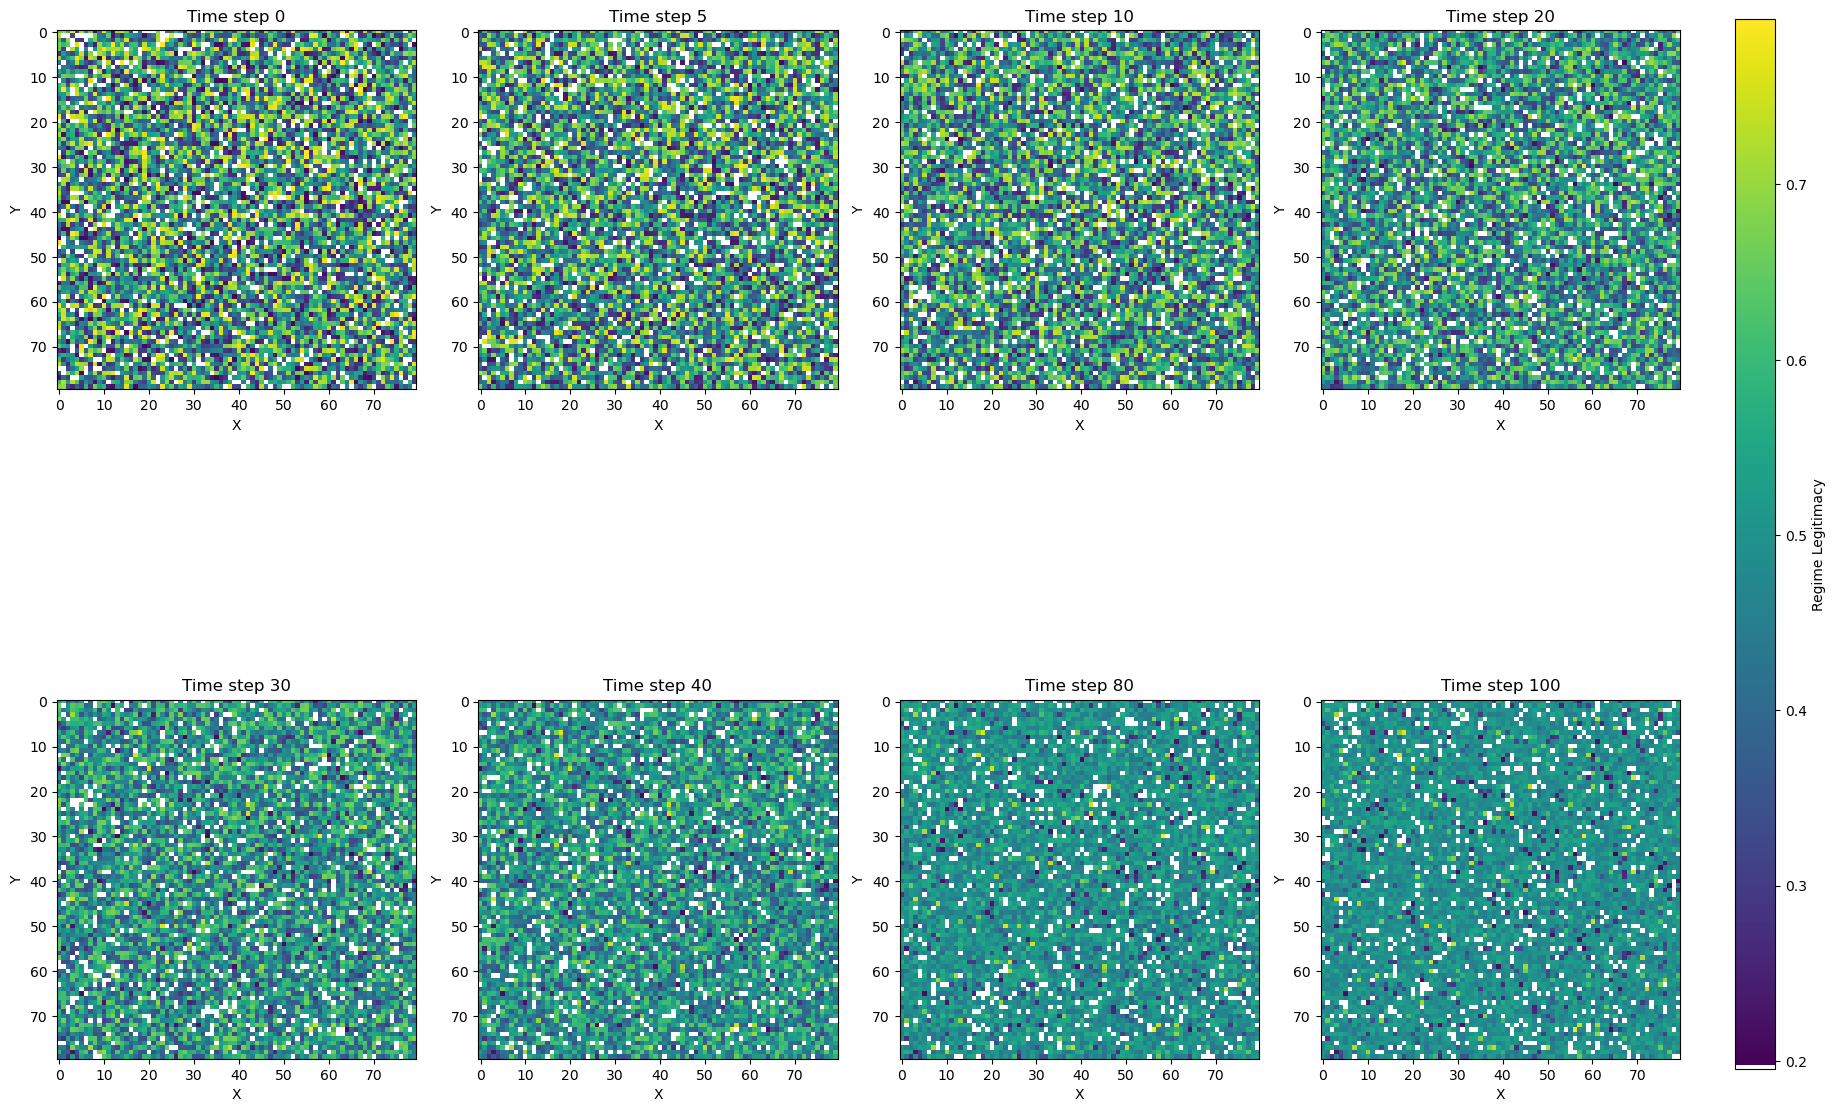

In [6]:
# heatmaps
time_steps = [0, 5, 10, 20, 30, 40, 80, 100]
plot_heatmaps(heter_heatmaps, time_steps)
heter_data = heter_model.datacollector.get_agent_vars_dataframe()

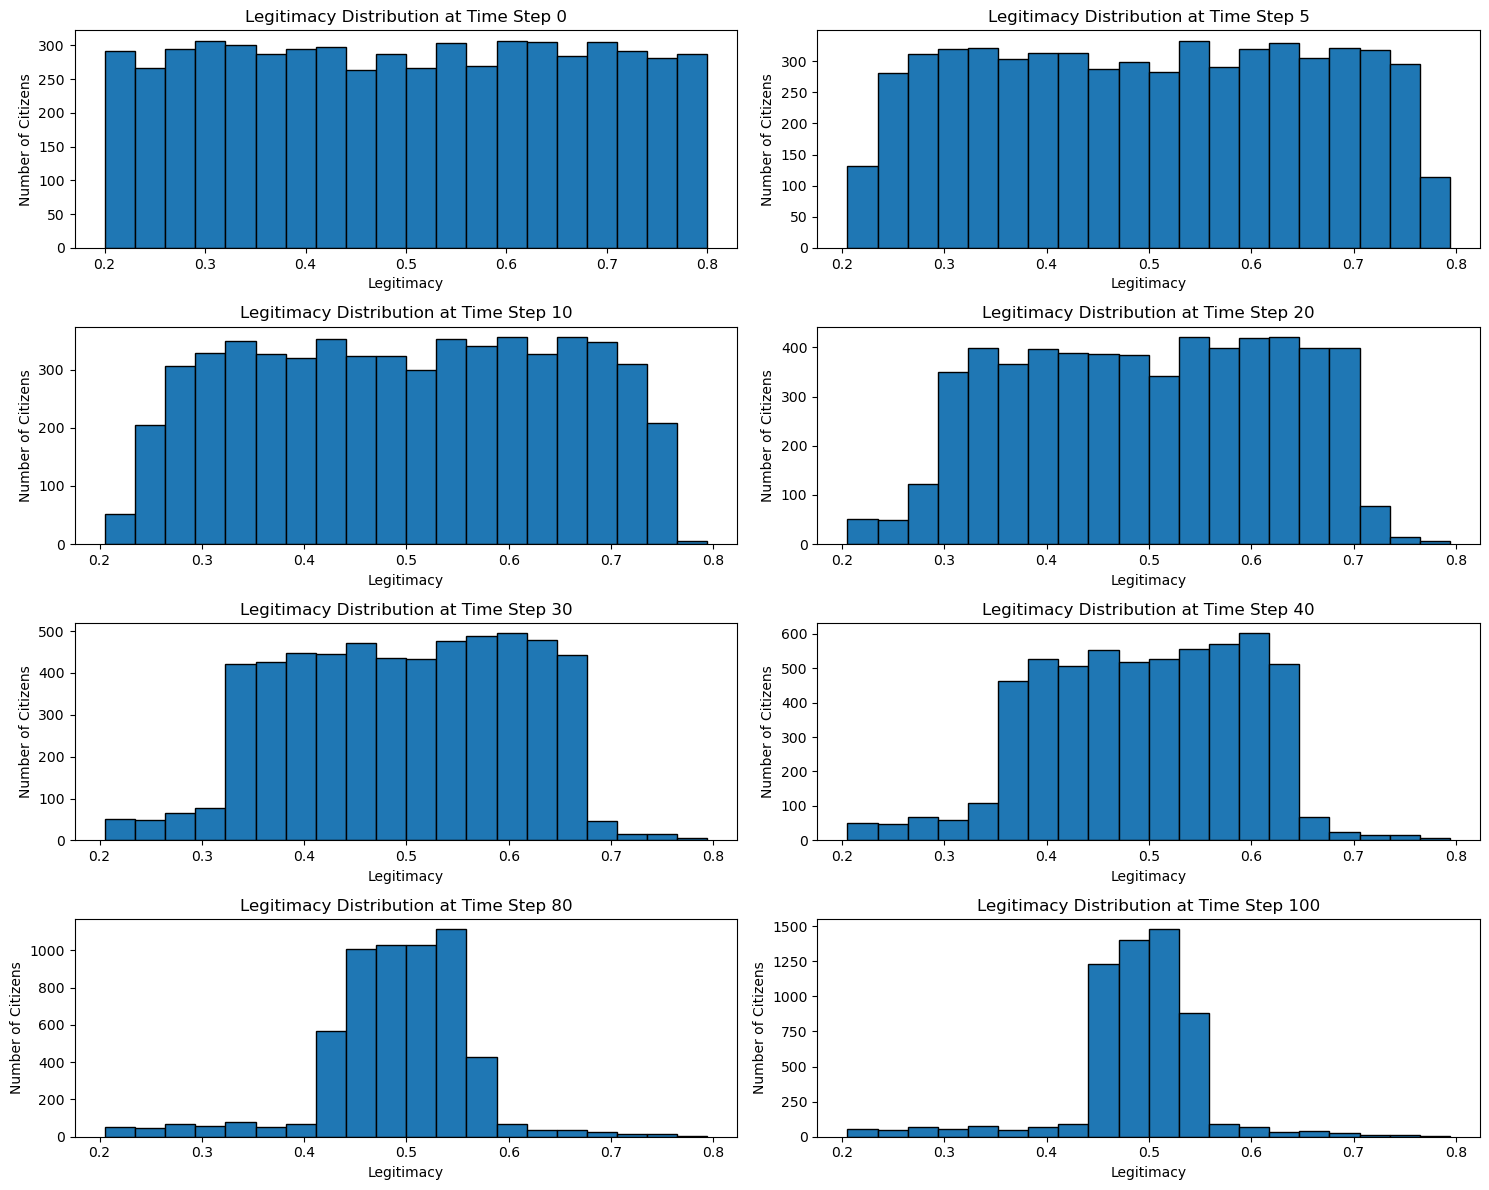

In [7]:
# Plot histograms
plot_legitimacy_histograms(heter_data, [0, 5, 10, 20, 30, 40, 80, 100])

Regional Heterogeneous Legitimacy:

In [8]:
# Regions
legitimacy_impact = 0.02
legitimacy_type = "by_regions"
legitimacy_matrix = np.array([
    [0.8, 0.6, 0.4],
    [0.6, 0.4, 0.2]
])
time_steps = [0, 5, 10, 20, 30, 40, 80, 100]
regions_model = create_model(legitimacy_impact, legitimacy_type, legitimacy_matrix, legitimacy_stability_threshold=0.1)
regions_heatmaps = run_model_and_collect_data_over_time(regions_model, time_steps)

C:\Users\liaojw\AppData\Local\Temp\ipykernel_42512\3615908245.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


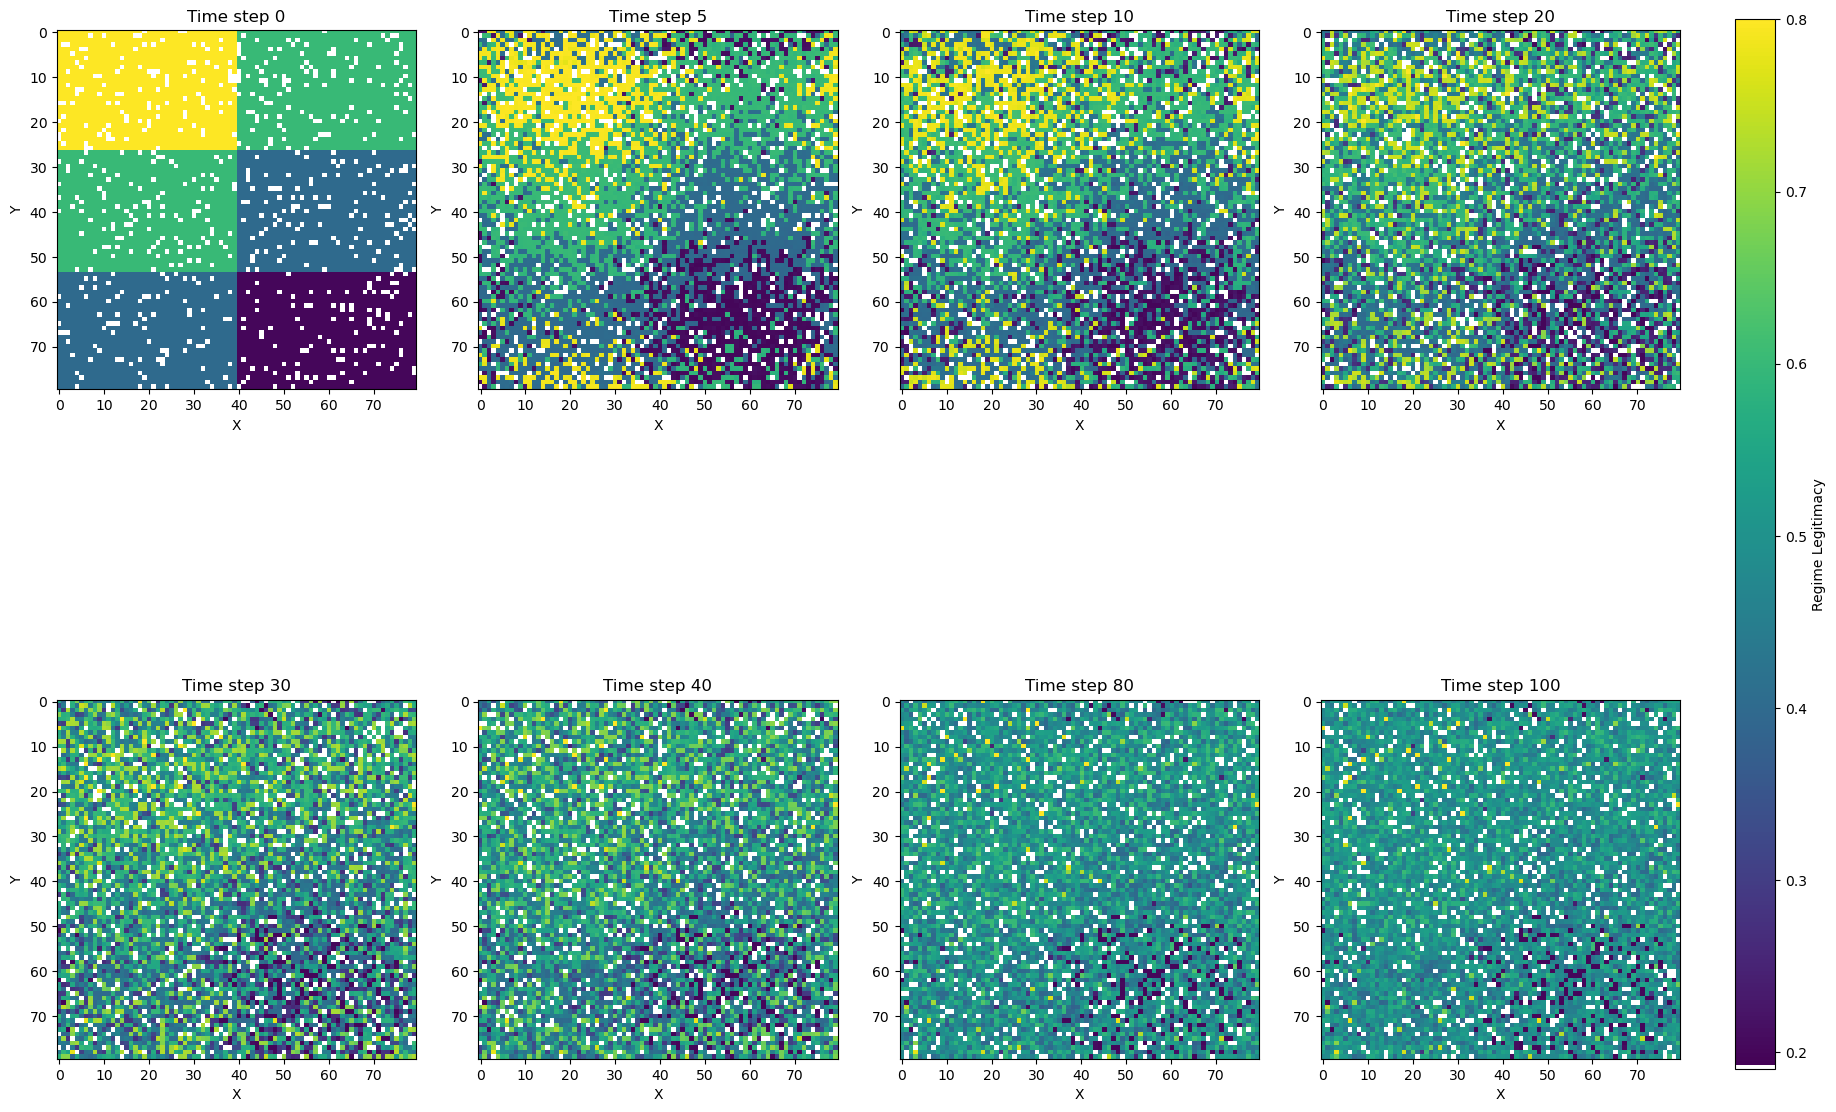

In [9]:
plot_heatmaps(regions_heatmaps, time_steps)
regions_data = regions_model.datacollector.get_agent_vars_dataframe()

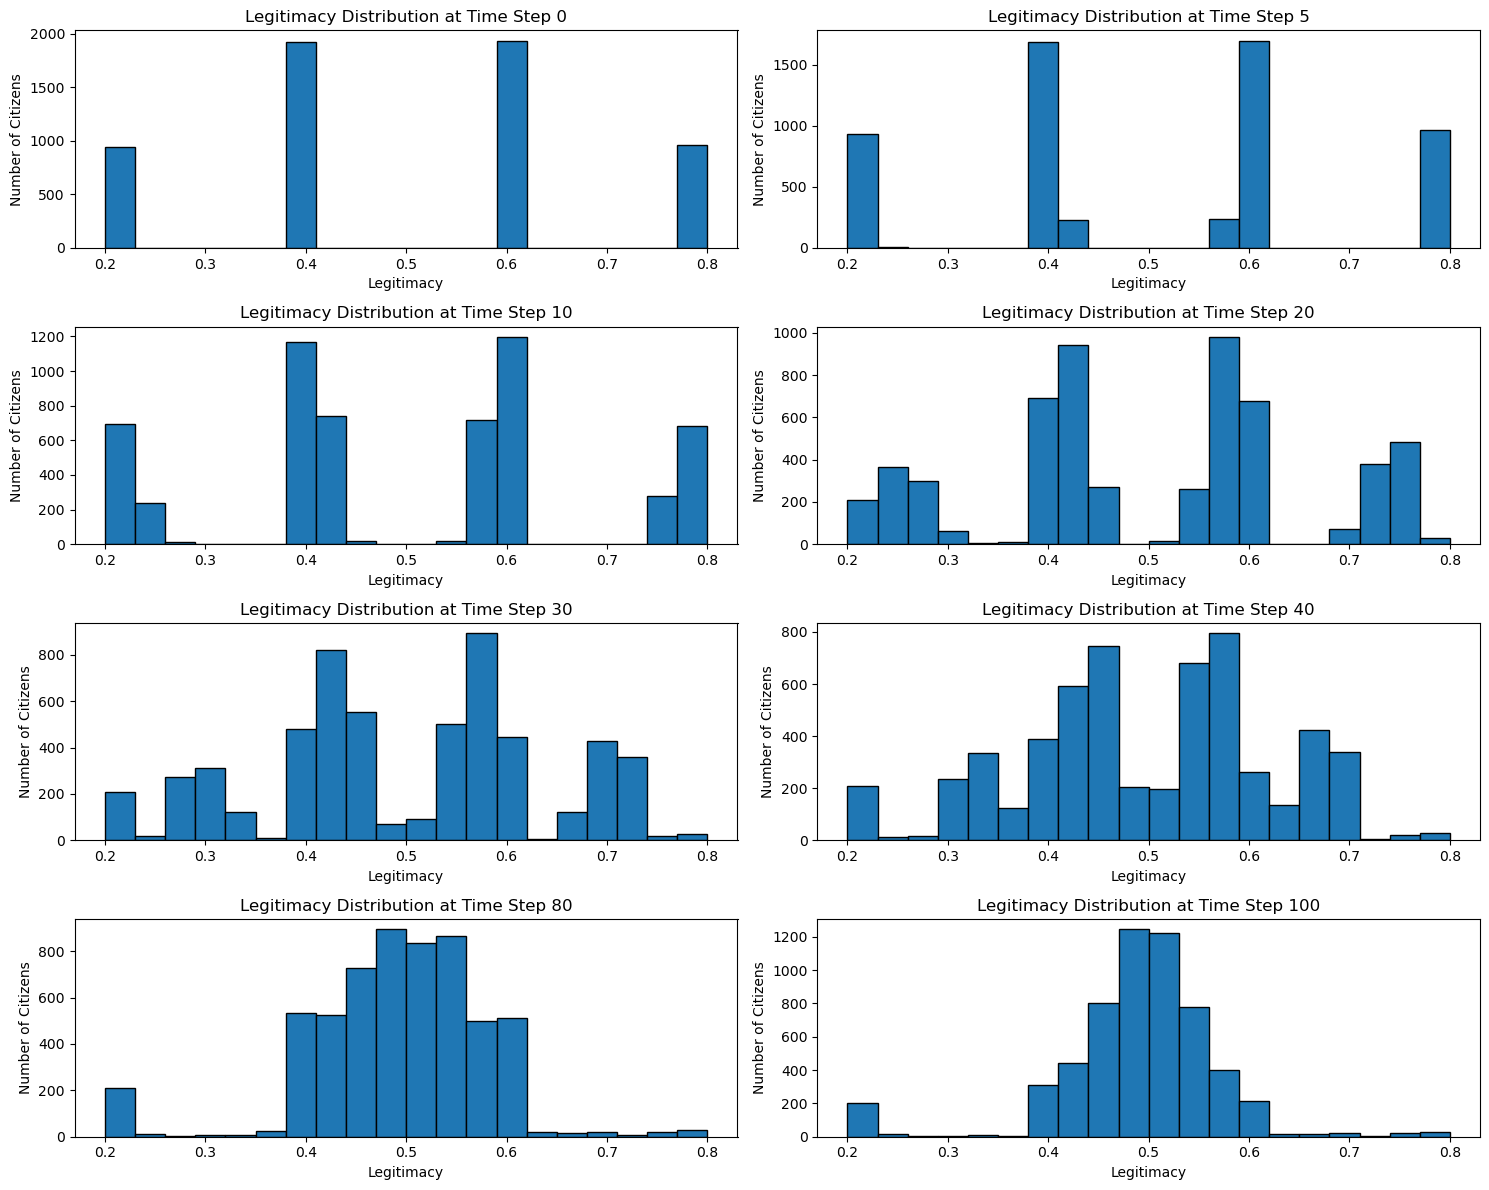

In [10]:
# Plot histograms
plot_legitimacy_histograms(regions_data, [0, 5, 10, 20, 30, 40, 80, 100])

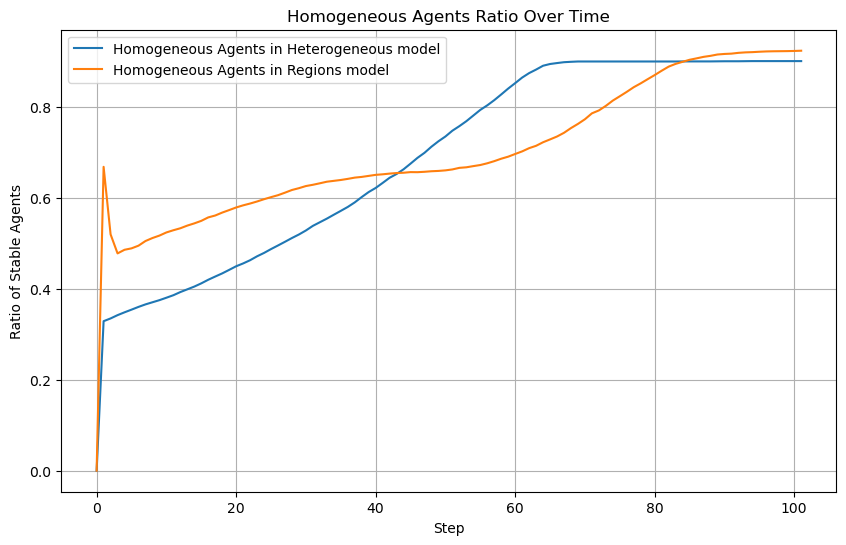

In [11]:
# homogeneous_ratio
plot_homogeneous_ratio([heter_model, regions_model], ["Heterogeneous", "Regions"])

## For outline

In [12]:
# Function to create a custom colormap
def create_colormap():
    """
    Create a colormap with 0 as white and the rest as 'viridis'.
    Returns:
        ListedColormap: Custom colormap
    """
    cmap = plt.cm.viridis
    # Make 0 into white
    colors = cmap(np.arange(cmap.N))
    colors[0, :] = np.array([1, 1, 1, 1])
    new_cmap = ListedColormap(colors)
    return new_cmap

# Function to create a model instance with specific parameters
def create_model(legitimacy_impact=0.1, legitimacy_type="heterogeneous", legitimacy_matrix = None, legitimacy=0.8, legitimacy_width=0.1, citizen_density=0.9):
    """
    Create an instance of EpsteinNetworkCivilViolence model with specific parameters.
    Args:
        legitimacy_impact (float): The impact of legitimacy to use in the model
        legitimacy_matrix (np.array): Matrix specifying the legitimacy by regions
    Returns:
        model: An instance of the model
    """
    model = EpsteinNetworkCivilViolence(
        width=80,
        height=80,
        citizen_density=0.9,
        cop_density=0.074,
        citizen_vision=7,
        cop_vision=7,
        legitimacy=legitimacy,
        max_jail_term=1000,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=300,
        alpha=0.1,
        jail_factor=1.1,
        legitimacy_impact=legitimacy_impact,
        legitimacy_type=legitimacy_type,
        legitimacy_matrix=legitimacy_matrix,
        use_mean_field=True,
        legitimacy_width=legitimacy_width,
        cop_density_mode='constant',
        legitimacy_mode='constant'
    )
    return model

# Function to run the model and collect heatmap data at specified time steps
def run_model_and_collect_data_single(model, time_steps):
    """
    Run the model and collect heatmap data at specified time steps.
    Args:
        model: An instance of the EpsteinNetworkCivilViolence model
        time_steps (list): List of time steps to capture
    Returns:
        list: Heatmap data for each time step
    """
    heatmaps = []
    for step in range(max(time_steps) + 1):
        model.step()
        if step in time_steps:
            agent_data = model.datacollector.get_agent_vars_dataframe()
            current_data = agent_data.xs(step, level='Step')
            inhabitant_data = current_data[current_data['breed'] == 'citizen']
            # Get x, y and regime_legitimacy
            x = inhabitant_data.x.values
            y = inhabitant_data.y.values
            legitimacy = inhabitant_data.regime_legitimacy.values
            grid_size = (80, 80)
            heatmap_data = np.zeros(grid_size)
            for i in range(len(x)):
                heatmap_data[int(x[i]), int(y[i])] = legitimacy[i]
            heatmaps.append(heatmap_data)
    return heatmaps

# Function to plot heatmaps
def plot_heatmaps(heatmaps, time_steps):
    """
    Plot heatmaps for each time step.
    Args:
        heatmaps (list): Heatmap data for each time step
        time_steps (list): List of time steps to capture
    """
    num_cols = 4
    num_rows = (len(time_steps) + num_cols - 1) // num_cols
    # fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    # axes = axes.flatten()
    cmap = create_colormap()

    for i, time_step in enumerate(time_steps):
        if i < len(time_steps):
            plt.figure(figsize=(10, 7))
            cmap = create_colormap()

            data_with_nan = np.where(heatmaps[i] == 0, np.nan, heatmaps[i])
            min_value = np.nanmin(data_with_nan)

            plt.figure(figsize=(10, 7))
            im = plt.imshow(heatmaps[i], cmap=cmap, interpolation='nearest', vmin=min_value-0.01, vmax=np.max(heatmaps[i]))
            plt.title(f'Time step {time_step}')
            plt.xlabel('X')
            plt.ylabel('Y')
            cbar = plt.colorbar(im, label='Regime Legitimacy')

            plt.tight_layout()
            plt.show()

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

<Figure size 1000x700 with 0 Axes>

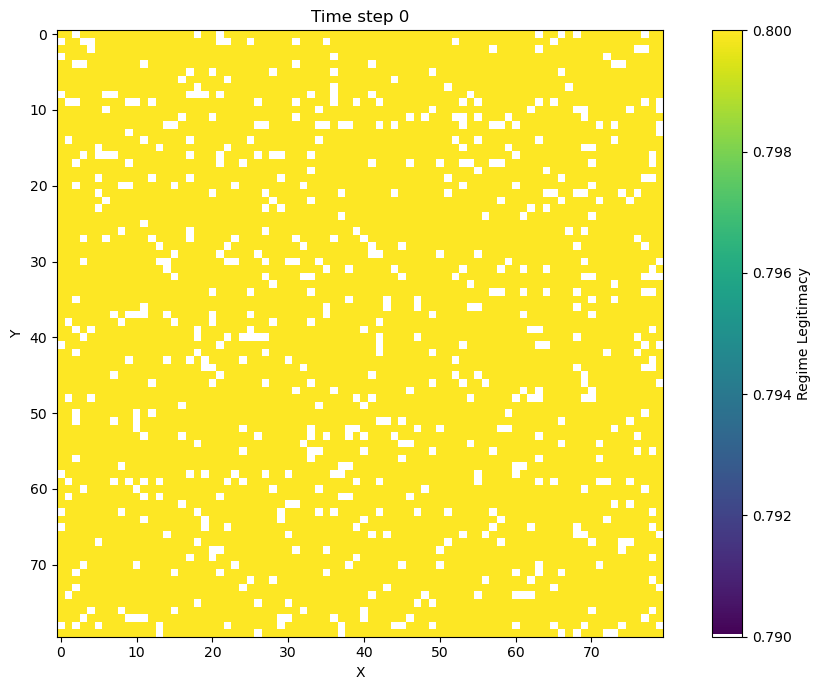

<Figure size 640x480 with 0 Axes>

In [13]:
# Main code execution, about 1m 46s to run
if __name__ == "__main__":
    legitimacy_type = "uniform"
    time_steps = [0]
    citizen_density=0.7
    model = create_model(legitimacy_type = legitimacy_type)
    heatmaps = run_model_and_collect_data_single(model, time_steps)
    plot_heatmaps(heatmaps, time_steps)

<Figure size 1000x700 with 0 Axes>

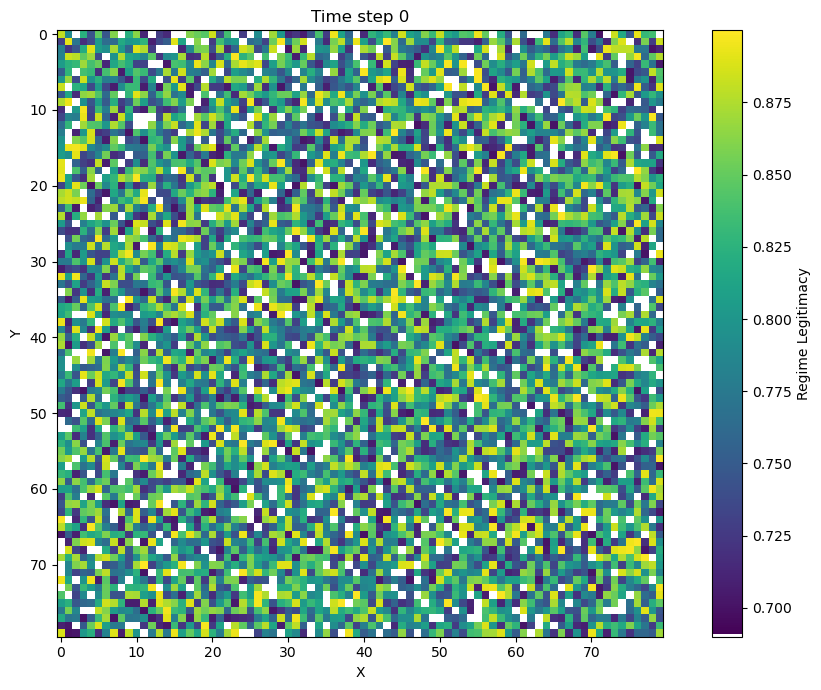

<Figure size 640x480 with 0 Axes>

In [14]:
# Main code execution, about 1m 46s to run
if __name__ == "__main__":
    legitimacy_type = "heterogeneous"
    time_steps = [0]
    citizen_density=0.7
    model = create_model(legitimacy_type = legitimacy_type)
    heatmaps = run_model_and_collect_data_single(model, time_steps)
    plot_heatmaps(heatmaps, time_steps)

<Figure size 1000x700 with 0 Axes>

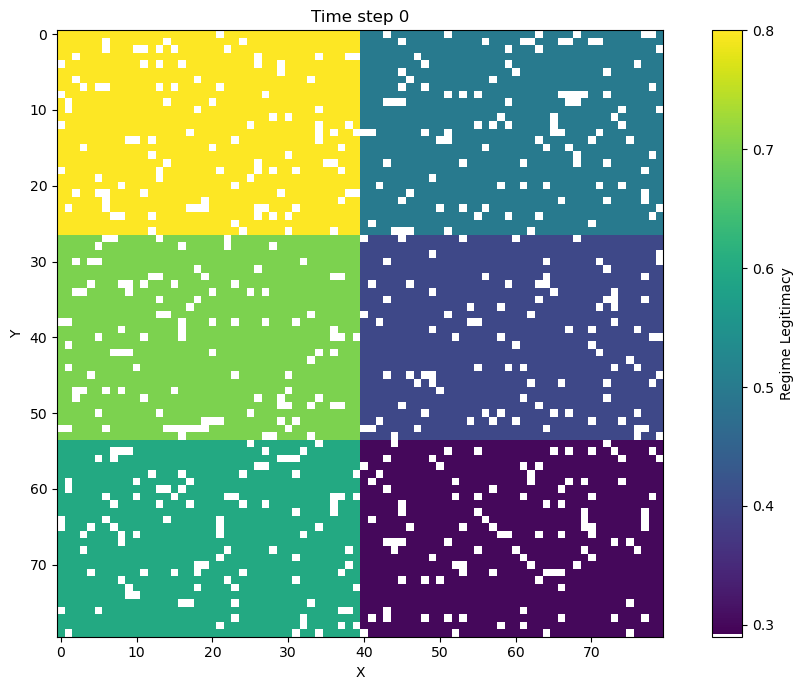

<Figure size 640x480 with 0 Axes>

In [15]:
# Main code execution, about 1m 46s to run
if __name__ == "__main__":
    legitimacy_type = "by_regions"
    legitimacy_matrix = np.array([
        [0.8, 0.7, 0.6],
        [0.5, 0.4, 0.3]
    ])
    time_steps = [0]
    model = create_model(legitimacy_impact, legitimacy_type, legitimacy_matrix)
    heatmaps = run_model_and_collect_data_single(model, time_steps)
    plot_heatmaps(heatmaps, time_steps)

In [16]:
# Function to run the model for a specified number of steps
def run_model(model, steps):
    """
    Run the model for a specified number of steps.
    Args:
        model: An instance of the EpsteinNetworkCivilViolence model
        steps (int): Number of steps to run the model
    """
    for _ in range(steps):
        model.step()

# Function to extract data from the model
def extract_data(model):
    """
    Extract agent data from the model's data collector.
    Args:
        model: An instance of the EpsteinNetworkCivilViolence model
    Returns:
        DataFrame: Agent data collected by the model
    """
    return model.datacollector.get_agent_vars_dataframe()

# Function to plot legitimacy distribution histograms at specified time steps
def plot_legitimacy_histograms(agent_data, time_steps):
    """
    Plot legitimacy distribution histograms at specified time steps.
    Args:
        agent_data (DataFrame): Agent data collected by the model
        time_steps (list): List of time steps to plot histograms for
    """
    fig, axs = plt.subplots(len(time_steps), 1, figsize=(10, 5))
    for i, step in enumerate(time_steps):
        step_data = agent_data.xs(step, level="Step")
        legitimacy_values = step_data['regime_legitimacy']
        print(legitimacy_values)

        # Plot histogram
        axs[i].hist(legitimacy_values, bins=20, edgecolor='black')
        axs[i].set_title(f'Legitimacy Distribution at Time Step {step}')
        axs[i].set_xlabel('Legitimacy')
        axs[i].set_ylabel('Number of Citizens')

    plt.tight_layout()
    plt.show()

Index(['x', 'y', 'breed', 'jail_sentence', 'condition', 'arrest_probability',
       'regime_legitimacy'],
      dtype='object')
AgentID
0       0.885388
1       0.888166
2       0.700932
3       0.711929
4       0.752417
          ...   
6241    0.891123
6242    0.887404
6243    0.782587
6244    0.874244
6245    0.798224
Name: regime_legitimacy, Length: 6246, dtype: float64
AgentID
588     0.843301
5608    0.761909
4135    0.819514
1204    0.781473
5904    0.760182
          ...   
189     0.752832
1913    0.829072
5758    0.812715
1529    0.772909
2355    0.787845
Name: regime_legitimacy, Length: 6246, dtype: float64


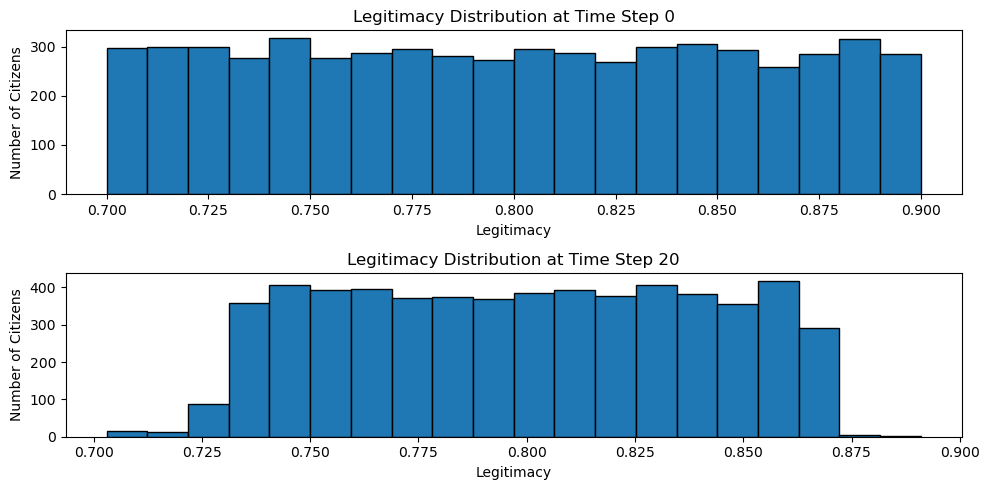

In [17]:
model = EpsteinNetworkCivilViolence(
    width=80,
    height=80,
    citizen_density=0.9,
    cop_density=0.074,
    citizen_vision=7,
    cop_vision=7,
    legitimacy=0.8,
    max_jail_term=1000,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=300,
    alpha=0.1,
    jail_factor=1.1,
    legitimacy_impact=0.02,
    legitimacy_type="heterogeneous", # "heterogeneous" or "uniform" or "by_regions"
    legitimacy_matrix=None,
    use_mean_field=True,
    legitimacy_width=0.1,
    cop_density_mode='constant',
    legitimacy_mode='constant'
)

# Run model
run_model(model, 22)

# Extract data
agent_data = extract_data(model)

# Check if "legitimacy" column exists
print(agent_data.columns)

# Define time steps to capture
time_steps = [0, 20]

# Plot histograms
plot_legitimacy_histograms(agent_data, time_steps)


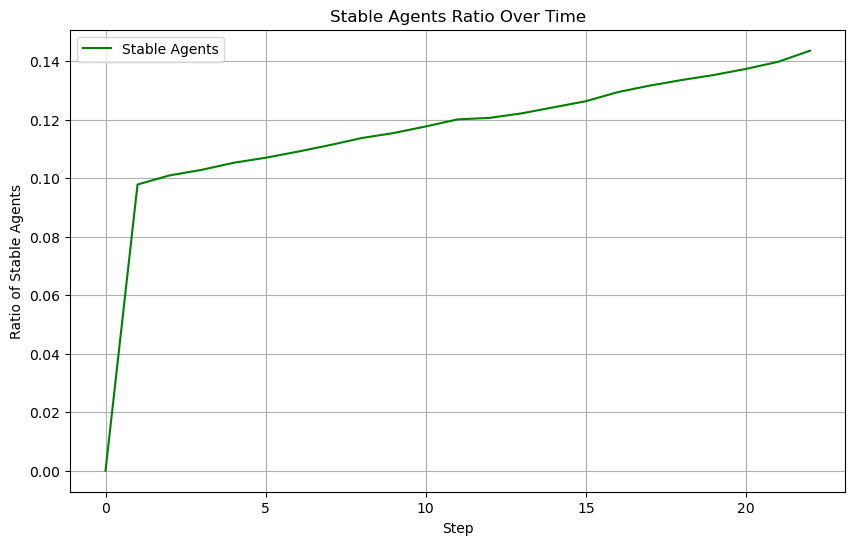

In [18]:
model_data = model.datacollector.get_model_vars_dataframe()
agent_num = model_data["Active"][0]+model_data["Jailed"][0]+model_data["Quiescent"][0]
# print(model_data["Stable Agents"])

stable_agents_data_per = model_data["Stable Agents"]/agent_num

plt.figure(figsize=(10, 6))
plt.plot(stable_agents_data_per, label='Stable Agents', color='green')
plt.xlabel('Step')
plt.ylabel('Ratio of Stable Agents')
plt.title('Stable Agents Ratio Over Time')
plt.legend()
plt.grid(True)
plt.show()

Index(['x', 'y', 'breed', 'jail_sentence', 'condition', 'arrest_probability',
       'regime_legitimacy'],
      dtype='object')
AgentID
0       0.8
1       0.8
2       0.8
3       0.8
4       0.8
       ... 
6237    0.3
6238    0.3
6239    0.3
6240    0.3
6241    0.3
Name: regime_legitimacy, Length: 6242, dtype: float64
AgentID
1747    0.538851
4455    0.547475
5273    0.300741
5090    0.606003
3863    0.530972
          ...   
1995    0.542610
330     0.562851
1761    0.540741
1614    0.534037
955     0.537305
Name: regime_legitimacy, Length: 6242, dtype: float64


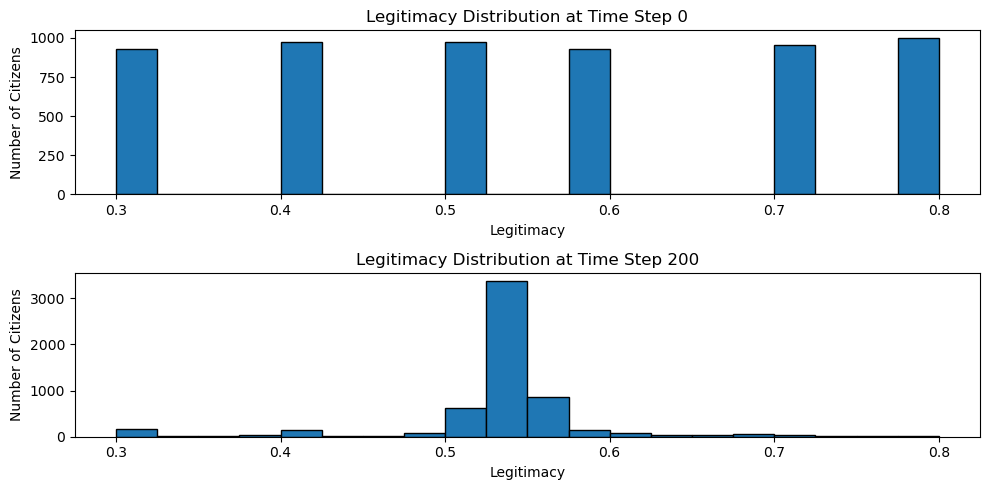

In [19]:
# Main code execution
if __name__ == "__main__":
    legitimacy_impact = 0.02
    legitimacy_type = "by_regions"
    legitimacy_matrix = np.array([
        [0.8, 0.7, 0.6],
        [0.5, 0.4, 0.3]
    ])
    time_steps = [0, 200]
    model = create_model(legitimacy_impact, legitimacy_type, legitimacy_matrix)
    # Run model
    run_model(model, 220)

    # Extract data
    agent_data = extract_data(model)

    # Check if "legitimacy" column exists
    print(agent_data.columns)
    # Plot histograms
    plot_legitimacy_histograms(agent_data, time_steps)

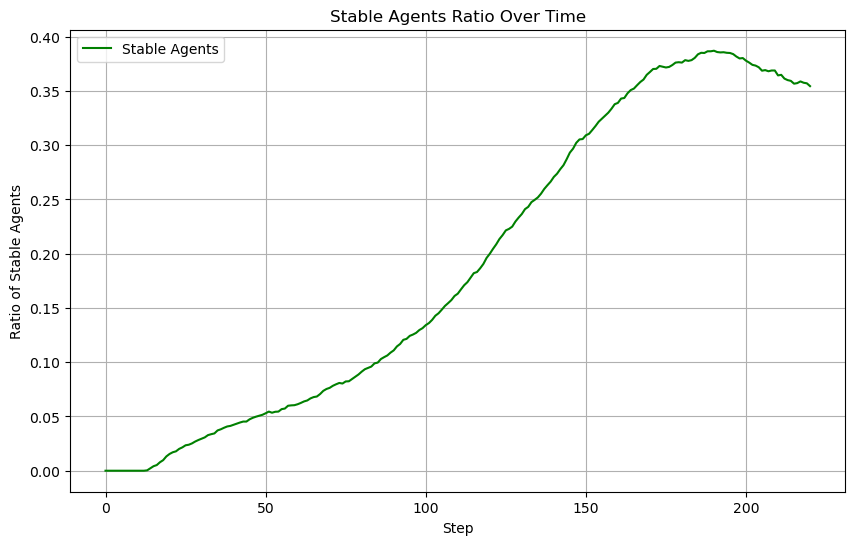

In [20]:
model_data = model.datacollector.get_model_vars_dataframe()
agent_num = model_data["Active"][0]+model_data["Jailed"][0]+model_data["Quiescent"][0]
# print(model_data["Stable Agents"])

stable_agents_data_per = model_data["Stable Agents"]/agent_num

plt.figure(figsize=(10, 6))
plt.plot(stable_agents_data_per, label='Stable Agents', color='green')
plt.xlabel('Step')
plt.ylabel('Ratio of Stable Agents')
plt.title('Stable Agents Ratio Over Time')
plt.legend()
plt.grid(True)
plt.show()